# Feature Selection Methods

In [1]:
def minimum_feature_selection(df, incl_target = False):
    # Don't select NA columns, don't select giveaway columns

    cols_with_na = df.isna().any()
    na_columns = df.columns[cols_with_na]
    cleaned = df.loc[:, ~cols_with_na]

    if not incl_target:
        cleaned = cleaned.drop(columns = ["CDRSUM"])

    cleaned = cleaned.drop(columns=[_ for _ in [
        "CDRGLOB",
        "COMMUN",
        "HOMEHOBB",
        "JUDGMENT",
        "ORIENT",
        "PERSCARE",
        "MEMORY",
        "var_cdrsum.x",
        "var_cdrsum.y",
        "var_cdrsum",
        "VISITDATE",
        "visitorder",
        "VISITDAY",
        "VISITMO",
        "VISITYR",
        "NACCUDSD",
        "NACCDAYS",
        "NACCMMSE",
        "NACCAVST",
        "NACCFDYS",
        "COURSE",
        "progression",
        "DECSUB...133",
        "DECSUB...174",
        "...7",
        "NACCADC",
        "interval",
        "NACCVNUM",
        "patient_id",
        "cluster",
        "classification.x",
        "classification.y",
        "classification",
        "NACCID", "visit_number",
    ] if _ in cleaned.columns])


    return cleaned.columns



In [2]:
import pandas as pd

minimum_feature_selection(pd.read_csv("seven_visits_train_new.csv"))

Index(['SEX', 'PRIMLANG', 'NACCAGE', 'NACCFADM', 'NACCFFTD', 'DECSUB...140',
       'DECSUB...194'],
      dtype='object')

## LASSO

In [3]:
import numpy as np
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


def lasso_selector(top_X: int, df):

    valid_input_cols = minimum_feature_selection(df)
    X = df[valid_input_cols]
    y = df["CDRSUM"]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)

    lasso = Lasso(alpha=0.01)
    lasso.fit(X_train_scaled, y_train)

    important_columns = np.argsort(np.abs(lasso.coef_))[-top_X:]
    important_features = X_train.columns[important_columns]

    return df[important_features.tolist() + ["CDRSUM"]]

## Random Forest

target column for this and supervised encoder is CDRSUM; only one visit needed to garner a relationship between input and output

In [4]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor


def random_forest(top_X : int, df):
    valid_input_cols = minimum_feature_selection(df)
    X = df[valid_input_cols]
    y = df["CDRSUM"]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)

    feature_importances = pd.Series(rf.feature_importances_, index=X.columns)

    return df[feature_importances.sort_values(ascending=False).head(top_X).index.tolist() + ["CDRSUM"]]

## Supervised Encoder

In [5]:
import gc

from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model


def supervised_encoder(df, *, epochs = 50, num_extract_features = 40):

  X = df.drop("CDRSUM", axis=1)  # Input features
  y = df["CDRSUM"]  # Response variable

  encoder = LabelEncoder()
  y_encoded = encoder.fit_transform(y)
  y_categorical = pd.get_dummies(y_encoded)

  y_train = y_categorical

  scaler = StandardScaler()
  X_train_scaled = scaler.fit_transform(X)

  inputs = Input(shape=(X_train_scaled.shape[1],))

  # Add the layers
  x = Dense(64, activation="relu")(inputs)
  x = Dense(64, activation="relu")(x)
  x = Dense(num_extract_features, activation="relu")(x)
  outputs = Dense(y_categorical.shape[1], activation="softmax")(x)

  # Create the model
  model = Model(inputs=inputs, outputs=outputs)
  model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

  model.fit(X_train_scaled, y_train, epochs=epochs, batch_size=16)

  return model, scaler
# PART 2: GET VALUES

def through_SDNN(df, model, scaler):

  X = df.drop("CDRSUM", axis=1)  # Input features
  y = df["CDRSUM"]

  encoder = LabelEncoder()
  y_encoded = encoder.fit_transform(y)
  y_categorical = pd.get_dummies(y_encoded)

  X_scaled = scaler.transform(X)


  import tensorflow as tf
  last_dense_layer_model = tf.keras.Model(inputs=model.input, outputs=model.layers[-2].output)


  output_values = last_dense_layer_model.predict(X_scaled, verbose=0)

  new_df = pd.DataFrame(output_values)
  new_df["CDRSUM"] = df.reset_index()["CDRSUM"]

  return new_df

def SE_driver(top_X : int, df):
  for_SE = df[minimum_feature_selection(df, incl_target=True)]
  model, scalar = supervised_encoder(for_SE, num_extract_features = top_X)
  transformed_SE_features = through_SDNN(for_SE, model, scalar)
  print(transformed_SE_features)
  return transformed_SE_features # includes CDRSUM

## RNN Start to End

In [6]:
import functools
from dataclasses import dataclass, field
from typing import Callable, Optional

import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping


@dataclass
class Data:
    raw: Optional[pd.DataFrame] = None
    clean: Optional[pd.DataFrame] = field(default_factory=lambda: pd.DataFrame())
    selected_features: Optional[pd.DataFrame] = None
    cdrsum_last_visit_of_input: Optional[pd.DataFrame] = None
    input_data: Optional[pd.DataFrame] = None
    input_matrix: Optional[np.ndarray] = None
    output_data: Optional[pd.DataFrame] = None
    output_matrix: Optional[np.ndarray] = None

@dataclass
class Parameters:
    feature_selector: Optional[Callable] = None
    num_features_selected: Optional[int] = None
    lstm_units_1: Optional[int] = None
    lstm_units_2: Optional[int] = None
    lstm_dropout_rate_1: Optional[float] = None
    lstm_dropout_rate_2: Optional[float] = None
    dense_dropout_rate: Optional[float] = None
    dense_layer_count: Optional[int] = None
    dense_units: Optional[int] = None
    loss_function: Optional[Callable] = None
    epochs: Optional[int] = None
    optimizer: Optional[Callable] = None
    learning_rate: Optional[float] = None

class RNN_Factory:

    def __init__(self, params, visit_inputs):
        self.data = Data()
        self.data.raw = pd.read_csv("data6.csv")
        self.clean_data()

        self.visit_inputs = visit_inputs

        self.params = params

    def clean_data(self):
        self.data.clean = self.data.raw.apply(lambda x: x.fillna(x.median()) if x.dtype.kind in "biufc" else x)

    def data_pipeline(self):
        self.data.input_data = self.data.clean

        self.data.input_data["progression"] = self.data.clean["progression"].astype("category")

        # Feature selection
        selector = functools.partial(self.params.feature_selector, self.params.num_features_selected)
        self.data.input_data = selector(self.data.clean)
        # self.data.input_data = self.data.clean[['CDRSUM', 'SEX'] + top_features]

        # numeric column conversion
        non_numeric_cols = self.data.input_data.select_dtypes(exclude=["number"]).columns
        self.data.input_data[non_numeric_cols] = self.data.input_data[non_numeric_cols].apply(lambda col: pd.to_numeric(col.astype(str), errors="coerce"))

        # INPUT DATA
        self.data.input_data = self.data.input_data.drop(columns=["CDRSUM"])

        # nice meta-variables
        self.num_samples = len(self.data.input_data) / self.visit_inputs
        self.timesteps = self.visit_inputs
        self.num_features = len(self.data.input_data.columns)

        self.data.input_matrix = self.data.input_data.to_numpy()
        self.data.input_matrix = self.data.input_matrix.reshape((int(self.num_samples), int(self.timesteps), int(self.num_features)))

        # create output data
        seven_visits_train_new = pd.read_csv("seven_visits_train_new.csv")
        _ = seven_visits_train_new.copy()
        _["visit_number"] = _.groupby("NACCID").cumcount() + 1
        patients_with_na = _.groupby("NACCID").filter(lambda x: x[["EDUC", "NACCAGE", "SEX"]].isna().any().any())

        _ = _[~_["NACCID"].isin(patients_with_na["NACCID"].unique())]

        output_data = _.groupby("NACCID").agg(
            cdrsum_4=("CDRSUM", lambda x: x[_["visit_number"] == 4].values[0] if (_["visit_number"] == 4).any() else None),
            cdrsum_5=("CDRSUM", lambda x: x[_["visit_number"] == 5].values[0] if (_["visit_number"] == 5).any() else None),
            cdrsum_6=("CDRSUM", lambda x: x[_["visit_number"] == 6].values[0] if (_["visit_number"] == 6).any() else None),
            cdrsum_7=("CDRSUM", lambda x: x[_["visit_number"] == 7].values[0] if (_["visit_number"] == 7).any() else None),
        ).reset_index()
        self.data.output_data = output_data
        self.data.output_data = self.data.output_data.sort_values("NACCID").fillna(0).drop(columns=["NACCID"])

        # Select the desired columns and convert to a NumPy matrix
        self.data.output_matrix = self.data.output_data[["cdrsum_4", "cdrsum_5", "cdrsum_6", "cdrsum_7"]].to_numpy()

    def build_train_model(self):

        model = models.Sequential()
        model.add(layers.LSTM(units=self.params.lstm_units_1, return_sequences=True, input_shape=(self.timesteps, self.num_features)))
        model.add(layers.Dropout(rate=self.params.lstm_dropout_rate_1))
        model.add(layers.LSTM(units=self.params.lstm_units_2))
        model.add(layers.Dropout(rate=self.params.lstm_dropout_rate_2))
        for i in range(self.params.dense_layer_count):
            model.add(layers.Dense(units=self.params.dense_units, activation="relu"))
            model.add(layers.Dropout(rate=self.params.dense_dropout_rate))
        model.add(layers.Dense(units=4, activation="linear", name="output"))

        early_stopping = EarlyStopping(
            monitor="val_loss",
            patience=10,
            # verbose=1,             # Prints a message when training stops
            restore_best_weights=True,
        )

        model.compile(
            loss=self.params.loss_function,
            optimizer=self.params.optimizer(self.params.learning_rate),
            metrics=["mean_absolute_error"],
        )

        history = model.fit(
            self.data.input_matrix,
            self.data.output_matrix,
            epochs=self.params.epochs,
            batch_size=256,
            validation_split=0.2,
            verbose=0,
            callbacks=[early_stopping],
        )

        return model, history


### Quick Test that data pipeline works

In [7]:
params = Parameters(feature_selector=random_forest, num_features_selected=40)
rnn = RNN_Factory(visit_inputs=3, params=params)
rnn.data_pipeline()

C:\Users\tminh\AppData\Local\Temp\ipykernel_18112\2087895995.py:41: DtypeWarning: Columns (30) have mixed types. Specify dtype option on import or set low_memory=False.
  self.data.raw = pd.read_csv('data6.csv')


### Custom Loss Functions

In [8]:
from tensorflow.keras import backend as K


def linear_weighted_mse(y_true, y_pred):
    y_true = K.reshape(y_true, shape=(-1, 4))
    y_pred = K.reshape(y_pred, shape=(-1, 4))

    max_y_true = 18.0

    weights = (max_y_true - K.mean(y_true, axis=-1)) / max_y_true
    weights_expanded = K.expand_dims(weights, axis=-1)
    mse = K.square(y_pred - y_true)
    weighted_mse = mse * weights_expanded
    weighted_mse_mean = K.mean(weighted_mse, axis=-1)

    return K.mean(weighted_mse_mean)


In [9]:

def weighted_mse(y_true, y_pred):
    y_true = K.reshape(y_true, shape=(-1, 4))
    y_pred = K.reshape(y_pred, shape=(-1, 4))

    # Calculate the weights
    weights = K.exp(-K.mean(y_true, axis=-1))

    weights_expanded = K.expand_dims(weights, axis=-1)

    mse = K.mean(K.square(y_pred - y_true), axis=-1)

    weighted_mse = mse * weights_expanded

    return K.mean(weighted_mse, axis=-1)


## Optuna Training Loop

#### ML Flow Setup

In a command prompt, make sure to run
mlflow server --host 127.0.0.1 --port 9000

In [10]:
import mlflow

mlflow.set_tracking_uri(uri="http://127.0.0.1:4002")

#### Light Data setup

#### Optuna Objective Function + ML Flow Logging

In [11]:
import io
from dataclasses import asdict

import matplotlib.pyplot as plt
from PIL import Image


def objective(trial):

    with mlflow.start_run(run_name=f"Trial #{trial.number}"):

        params = Parameters()
        params.feature_selector = trial.suggest_categorical("feature_selector", [
            random_forest,
            SE_driver,
            lasso_selector])
        params.num_features_selected = trial.suggest_int("num_features_selected", 5, 40)
        params.lstm_units_1 = trial.suggest_categorical("lstm_units_1", [32, 64, 128, 256])
        params.lstm_units_2 = trial.suggest_categorical("lstm_units_2", [32, 64, 128, 256])
        params.dense_units = trial.suggest_int("dense_units", 4, 20, log=True)
        params.lstm_dropout_rate_1 = trial.suggest_float("lstm_dropout_rate_1", 0.01, 0.5)
        params.lstm_dropout_rate_2 = trial.suggest_float("lstm_dropout_rate_2", 0.01, 0.5)
        params.dense_dropout_rate = trial.suggest_float("dense_dropout_rate", 0.01, 0.5)
        params.epochs = trial.suggest_int("epochs", 50, 150)
        params.loss_function = trial.suggest_categorical("loss_function", [weighted_mse, linear_weighted_mse])
        params.optimizer = trial.suggest_categorical("optimizer", [tf.keras.optimizers.Adam, tf.keras.optimizers.RMSprop, tf.keras.optimizers.Nadam])
        params.learning_rate = trial.suggest_categorical("learning_rate", [1e-5, 1e-4, 1e-3, 1e-2])
        params.dense_layer_count = trial.suggest_int("dense_layer_count", 1, 5)

        mlflow.log_params({k: repr(v) if callable(v) else v for k, v in asdict(params).items()})

        rnn = RNN_Factory(visit_inputs = 3, params = params)
        rnn.data_pipeline()
        model, history = rnn.build_train_model()


        mlflow.tensorflow.log_model(model, artifact_path = "model")

        mlflow.log_metric("training loss", history.history["loss"][-1])
        mlflow.log_metric("training MAE", history.history["mean_absolute_error"][-1])

        mlflow.log_metric("validation loss", history.history["val_loss"][-1])
        mlflow.log_metric("validation MAE", history.history["val_mean_absolute_error"][-1])


        # Plot the final training history
        plt.figure(figsize=(14, 6))

        # Plot Loss on the first subplot
        plt.subplot(1, 2, 1)
        plt.plot(history.history["loss"], label="Training Loss")
        plt.plot(history.history["val_loss"], label="Validation Loss")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.title("Training and Validation Loss")
        plt.legend()

        # Plot MAE on the second subplot
        plt.subplot(1, 2, 2)
        plt.plot(history.history["mean_absolute_error"], label="Training MAE")
        plt.plot(history.history["val_mean_absolute_error"], label="Validation MAE")
        plt.xlabel("Epochs")
        plt.ylabel("Mean Absolute Error")
        plt.title("Training and Validation MAE")
        plt.legend()

        # Adjust layout and show the plots
        plt.tight_layout()

        buf1 = io.BytesIO()
        plt.savefig(buf1, format="png")
        buf1.seek(0)
        plt.close()

        mlflow.log_image(Image.open(buf1), artifact_file = "plots.png")

        # Validation loss will be the primary optimizing factor
        return min(history.history["val_loss"])

#### Optuna Execution + ML Flow Experiment

In [12]:
from datetime import datetime

import optuna

id = datetime.now().strftime("%A, %B %d, %Y at %I:%M %p")
mlflow.set_experiment("RNN Optimization via Optuna " + id)

# telling optuna to use the TPESampler is unnecessary; that's default
# TPE means Tree structured Parzen estimator
study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler())
study.optimize(objective, n_trials=500, n_jobs=10)

# Print the best trial parameters
best_trial = study.best_trial
print(f"Best trial parameters: {best_trial.params}")


KeyboardInterrupt: 

# ML Flow Review

In [60]:
client = mlflow.tracking.MlflowClient()
experiments = client.search_experiments()
[_.name for _ in experiments]

['RNN Optimization via Optuna Sunday, August 18, 2024 at 01:03 AM',
 'RNN Optimization via Optuna Sunday, August 18, 2024 at 12:59 AM',
 'RNN Optimization via Optuna Sunday, August 18, 2024 at 12:31 AM',
 'RNN Optimization via Optuna Sunday, August 18, 2024 at 12:21 AM',
 'RNN Optimization via Optuna Sunday, August 18, 2024 at 12:20 AM',
 'RNN Optimization via Optuna Sunday, August 18, 2024 at 12:19 AM',
 'RNN Optimization via Optuna',
 'Default']

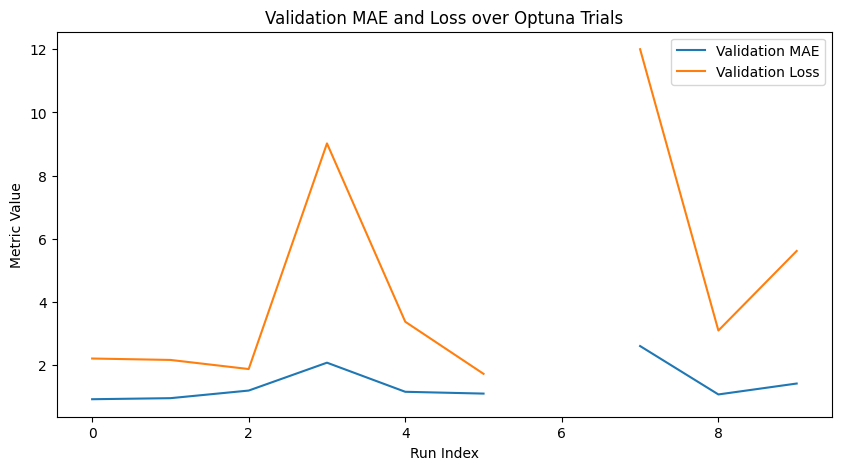

In [61]:
import mlflow
import pandas as pd

client = mlflow.tracking.MlflowClient()

experiment_name = "RNN Optimization via Optuna Sunday, August 18, 2024 at 01:03 AM"
experiment = client.get_experiment_by_name(experiment_name)

runs = client.search_runs(experiment.experiment_id, filter_string="attributes.status = 'FINISHED'")

data = []
for run in runs:
    data.append({
        "mae": run.data.metrics.get("validation MAE"),
        "loss": run.data.metrics.get("validation loss"),
    })

df = pd.DataFrame(data)
# df = df.sort_values(by='run_id')  # Ensure order is by time

plt.figure(figsize=(10, 5))
plt.plot(df["mae"], label="Validation MAE")
plt.plot(df["loss"], label="Validation Loss")
plt.xlabel("Run Index")
plt.ylabel("Metric Value")
plt.title("Validation MAE and Loss over Optuna Trials")
plt.legend()
plt.show()


## Optuna Best Model

In [18]:
# You can then train the model with the best batch size like this:
best_batch_size = study.best_trial.params["batch_size"]

model = models.Sequential()
model.add(layers.LSTM(units=32, return_sequences=True, input_shape=(timesteps, num_features)))
model.add(layers.LSTM(units=50))
model.add(layers.Dense(units=4, activation="linear", name="output"))

model.compile(
    loss=weighted_mse,  # Use the custom weighted MSE loss function
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["mean_absolute_error"],
)

history = model.fit(
    input_data,
    output_matrix,
    epochs=60,
    batch_size=best_batch_size,
    validation_split=0.2,
)

# Plot the final training history
plt.plot(history.history["loss"], label="Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.plot(history.history["mean_absolute_error"], label="MAE")
plt.plot(history.history["val_mean_absolute_error"], label="Validation MAE")
plt.xlabel("Epochs")
plt.ylabel("Metrics")
plt.legend()
plt.show()


KeyError: 'batch_size'